### Finding good Lower Triangular $A$

In [1]:
import sys
import itertools

from tqdm import tqdm

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

sys.path.append("..")
import helper.helper as h

from sklearn.linear_model import OrthogonalMatchingPursuitCV
from sklearn.linear_model import LassoLars
from sklearn.linear_model import Lasso

ModuleNotFoundError: No module named 'statsmodels.api.OLS'; 'statsmodels.api' is not a package

Generate a random $A$, with $\texttt{num_edges}$, where the edge weights are between $0.5$ and $1.0$. The matrix $A$ is lower triangular, but allows for entries to be non-zero on the diagonal.

In [22]:
def generate_A(n, num_edges):
    edges = np.array([0.0] * (int(n * (n + 1) / 2) - num_edges) + [1.0] * num_edges)
    
    edges[edges > 0] = (2 * np.random.randint(0, 2, size=(num_edges)) - 1) * np.random.uniform(0.5, 0.75, num_edges)
    np.random.shuffle(edges)
    
    A = np.zeros((n, n))
    A[np.tril_indices(n)] = edges
    
    return A

Generate data according to a VAR(1) model with $P^TAP$ as matrix. $\texttt{n}$-dimensional, $\texttt{s}$ non-zero entries, $\texttt{T}$ samples.

A:
[[ 0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.  ]
 [-0.65  0.58 -0.66  0.    0.  ]
 [ 0.    0.    0.    0.53  0.  ]
 [ 0.    0.71 -0.56  0.    0.  ]]

P:
[[0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]].

W:
[[ 0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.  ]
 [ 0.71  0.    0.   -0.56  0.  ]
 [ 0.58 -0.65  0.   -0.66  0.  ]
 [ 0.    0.    0.    0.    0.53]].


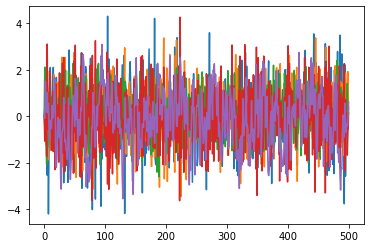

In [27]:
## Number of dimensions, number of edges, number of samples
T, n, s = 500, 5, 6

## Coefficient matrix
A_true = generate_A(n, s)

## True permutation
P_true = np.random.permutation(np.identity(n))

## Generate series
X = h.generate_var_2(T, n, A_true, P_true)
plt.plot(X);

print(f"A:\n{np.round(A_true, 2)}\n\nP:\n{P_true}.\n\nW:\n{np.round(P_true.T @ A_true @ P_true, 2)}.")

In [28]:
W_true = P_true.T @ A_true @ P_true
print(f"Original W:\n{np.round(W_true, 2)}.\n")

W_1, O_1 = get_W_0_v1(X)
print(f"W by iteratively zero'ing smallest element:\n{np.round(W_1, 2)}.\n")

W_2, O_2 = get_W_0_v2(X)
print(f"W using sm.OLS_regularized:\n{np.round(W_2, 2)}.\n")

W_3, O_3 = get_W_0_v3(X)
print(f"W using OLS regularized incorrect:\n{np.round(W_3, 2)}.\n")

W_4 = get_W_0_v4(X)
print(f"W using OMP:\n{np.round(W_4, 2)}.\n")

W_5, O_5 = get_W_0_v5(X)
print(f"W using LassoLARS:\n{np.round(W_5, 2)}.\n")

W_6, O_6 = get_W_0_v6(X)
print(f"W using Lasso:\n{np.round(W_6, 2)}.\n")

print(f"Order W_1:\n{permute(O_1)}.\n")
print(f"Order W_2:\n{permute(O_2)}.\n")
print(f"Order W_3:\n{permute(O_3)}.\n")

Original W:
[[ 0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.  ]
 [ 0.71  0.    0.   -0.56  0.  ]
 [ 0.58 -0.65  0.   -0.66  0.  ]
 [ 0.    0.    0.    0.    0.53]].

W by iteratively zero'ing smallest element:
[[ 0.    0.    0.    0.    0.  ]
 [ 0.07  0.    0.    0.    0.  ]
 [ 0.74  0.    0.   -0.59  0.  ]
 [ 0.57 -0.56  0.   -0.62  0.  ]
 [ 0.06  0.    0.    0.    0.58]].

Smallest alpha for DAG: 0.2.
W using sm.OLS_regularized:
[[ 0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.  ]
 [ 0.51  0.    0.   -0.36  0.  ]
 [ 0.47 -0.48  0.   -0.5   0.  ]
 [ 0.    0.    0.    0.    0.45]].

Smallest alpha for DAG: 0.1.
W using OLS regularized incorrect:
[[ 0.    0.   -0.    0.   -0.  ]
 [ 0.   -0.    0.    0.   -0.  ]
 [ 0.64  0.   -0.   -0.49 -0.  ]
 [ 0.47 -0.46 -0.   -0.52 -0.  ]
 [ 0.    0.   -0.    0.    0.48]].

W using OMP:
[[ 0.    0.   -0.02  0.    0.  ]
 [ 0.07  0.    0.    0.    0.  ]
 [ 0.74  0.    0.   -0.58  0.  ]
 [ 0.56 -0.59  0.   -0.61  0.  ]
 [ 0.0

We want to find a good permutation $P$. One approach is to first estimate $A$ using e.g. ordinary least squares, and from there find the correspond permutation. In the population setting, this works flawlessly. However, for limited data samples, we might get some entries in $\hat{A}_{OLS}$ that slightly deviate from zero. This could mess up the "DAG-ness" of our matrix $\hat{A}_{OLS}$. For this, we have multiple solutions:

1. Compute $\hat{A}_{OLS}$, which denotes the least squares solution, i.e., $$\hat{A}_{OLS} = \arg \min \left\lVert \mathbf{X}_{[1:T]} - \mathbf{X}_{[0:T-1]}\right\rVert_2^2$$ and set the smallest (in absolute value) non-zero entry to zero until $\hat{A}_{OLS}$ is a DAG.
2. Compute $\hat{A}_{RLS(\alpha)}$, which denotes the $\ell_1$-regularized solution with penalty $\alpha$, so $$\hat{A}_{RLS(\alpha)} = \arg \min \left\lVert \mathbf{X}_{[1:T]} - \mathbf{X}_{[0:T-1]}\right\rVert_2^2 + \alpha \left\lVert W \right\rVert_1$$ and increase the value for $\alpha$ from 0 until $\hat{A}_{RLS(\alpha)}$ is a DAG.
    1. Can be done using ``sm.OLS(y[:, i], x).fit_regularized(alpha = alpha, L1_wt = 1.0)``
    2. Can be done using $\hat{A}_{RLS(\alpha)} = \hat{A}_{OLS} \cdot \max\left(0, 1 -\frac{T \alpha}{|\hat{A}_{OLS}|}\right)$. This approach requires $\mathbf{X}$ to be orthonormal, i.e., $\mathbf{X}^T \mathbf{X} = I$. This is $\textbf{not}$ the case, however!

Given data $\mathbf{X}$ and a permutation $P$, find the least squares solution $\hat{A}_{OLS}$, where $\hat{A}_{OLS}$ is lower triangular and $$W = P^TAP.$$

So, for $X_{\pi(1)}$, we can only use that variable. For $X_{\pi(2)}$, we can only use $X_{\pi(1)}$ and that variable, etc., until $X_{\pi(n)}$, where we can use all variables. 

# Initialization for $P_0$
What value shoudl $P_0$ be? Could be the identity, but that could be very far off from the actual permutation. A better strategy is to e.g. perform ordinary least squares on the VAR(1) model to estimate $\hat{W}$. Note that $\hat{W}$ is not necessarily the WAM of a DAG. To massage $\hat{W}$ into the WAM of a DAG, we iteratively set the smallest element (in absolute value) $w_{ij}$ to zero, until we have a WAM compatible with a DAG.

We first do OLS to get $A$

In [4]:
def is_dag(W_input):
    n = W_input.shape()[0]
    
    W = W_input.copy()
    # remove diagonal entries
    np.fill_diagonal(W, 0)
    
    order, old_order = [], list(range(n))
    
    # for the number of elements
    for i in range(n):
        
        # find a row that contains only zeros
        for j in range(n - i):
            # if we find a zero row (excl. diags)
            if not W[j].any() != 0:
                
                # remove this row and column
                W = np.delete(W, j, 0)
                W = np.delete(W, j, 1)
            
                order.append(old_order[j])
                old_order.remove(old_order[j])
                
                # go to next variable
                break
        
            # if no zero row exist stop
            elif i == n - 1:
                return False
            
    return True, order

In [5]:
def permute(order):
    P = np.zeros((n, n))
    for idx, elem in enumerate(order):
        P[idx][elem] = 1
    return P

In [6]:
def get_W_0_v1(X):
    W_hat = rls_W(X, 0.0)
    
    while not is_dag(W_hat):
        # Get the indices of minimum element in numpy array
        # little trickery to skip zero values
        W_hat[W_hat == 0] = np.inf
        min_loc = np.where(np.abs(W_hat) == np.amin(np.abs(W_hat)))
        W_hat[W_hat == np.inf] = 0

        # set minimum value to zero
        W_hat[min_loc] = 0

    return W_hat, is_dag(W_hat)[1]

In [7]:
def rls_W(X, alpha):
    # get regressor and varibles
    y = X[1:]
    x = X[:-1]

    W_hat = np.array([])

    # get parameters
    for i in range(n):
        est = sm.OLS(y[:, i], x).fit_regularized(alpha = alpha, L1_wt = 1.0)
        W_hat = np.append(W_hat, est.params)

    W_hat = W_hat.reshape((n, n)).T
    
    return W_hat

In [8]:
def get_W_0_v2(X):
    # initial L1 penalty
    alpha = 0.0
    
    # get W_hat with this penalty
    W_hat = rls_W(X, 0.0)
    
    while not is_dag(W_hat):
        alpha += 0.1
        W_hat = rls_W(X, alpha)

    print(f"Smallest alpha for DAG: {round(alpha, 2)}.")
    return W_hat, is_dag(W_hat)[1]

In [9]:
def get_W_0_v3(X):
    # initial L1 penalty
    alpha = 0.0
    
    # get W_Hat with this penalty
    W_ols = rls_W(X, 0.0)
    W_hat = W_ols.copy()
    
    while not is_dag(W_hat):
        alpha += 0.1
        W_hat *= np.maximum(0, 1 - alpha / np.abs(W_ols)) 

    print(f"Smallest alpha for DAG: {round(alpha, 2)}.")
    return W_hat, is_dag(W_hat)[1]

In [10]:
alpha = 0.5

W_rls = rls_W(X, alpha)
W_edges_rls = W_rls.copy()
W_edges_rls[W_edges_rls != 0] = 1

W_edges_true = W_true.copy()
W_edges_true[W_edges_true != 0] = 1

print(f"W_RLS:\n{W_edges_rls}.\n")
print(f"W_True:\n{W_edges_true}.\n")

W_edges_true[W_edges_true == 0] = -1
C = (W_edges_rls == -W_edges_true)
D = (C == 1.0)

print(f"Edges that were not in W_true but are in W_rls with alpha = {round(alpha, 2)}:\n{D.astype(float)}.\n")

W_edges_true[W_edges_true == -1] = 0
W_edges_rls[W_edges_rls == 0] = -1
C = (W_edges_rls == -W_edges_true)
D = (C == 1.0)

print(f"Edges that were not in W_rls but are not in W_true with alpha = {round(alpha, 2)}:\n{D.astype(float)}.")

NameError: name 'W_true' is not defined

### Conclusion
The RLS method seems to perform poorly. The coefficients of the OLS solution that violate the acyclicity constraint are very small (all $< 0.1$), it seems that the RLS method first starts to decrease other coefficients, such that the final RLS solution has lost a lot of the "true" coefficients. Much more than the "set smallest value to zero" method; that one seems to work much better in practice.

It mostly depends on the sparsity of the graph. When the graph is sparse, it seems that RLS method performs better. When the graph is dense, it seems to regularize true edges before false edges (a true 0.5 edge is sometimes weighed out earlier than an incorrect 0.02 edge).

In [11]:
def get_W_0_v4(X):
    # plot the noise-free reconstruction
    omp = OrthogonalMatchingPursuitCV()

    W_OMP = np.array(np.zeros(n))

    for i in range(n):
        omp_fit = omp.fit(X[:-1], X[1:, i])
        coef = omp_fit.coef_
        W_OMP = np.vstack((W_OMP, coef))

    return W_OMP[1:].T

In [12]:
def lasso_lars_W(X, alpha):
    # get regressor and varibles
    y = X[1:]
    x = X[:-1]

    W_hat = np.array([])

    reg = LassoLars(alpha=alpha, normalize=False)
    
    # get parameters
    for i in range(n):
        est = reg.fit(x, y[:, i])
        W_hat = np.append(W_hat, est.coef_)

    W_hat = W_hat.reshape((n, n)).T
    
    return W_hat

In [13]:
def get_W_0_v5(X):
    # initial L1 penalty
    alpha = 0.0
    
    # get W_Hat with this penalty
    W_ols = rls_W(X, 0.0)
    W_hat = W_ols.copy()
    
    while not is_dag(W_hat):
        alpha += 0.1
        W_hat = lasso_lars_W(X, alpha)

    print(f"Smallest alpha for DAG: {round(alpha, 2)}.")
    return W_hat, is_dag(W_hat)[1]

In [14]:
def lasso_W(X, alpha):
    # get regressor and varibles
    y = X[1:]
    x = X[:-1]

    W_hat = np.array([])

    reg = Lasso(alpha=alpha, normalize=False)
    
    # get parameters
    for i in range(n):
        est = reg.fit(x, y[:, i])
        W_hat = np.append(W_hat, est.coef_)

    W_hat = W_hat.reshape((n, n)).T
    
    return W_hat

In [15]:
def get_W_0_v6(X):
    # initial L1 penalty
    alpha = 0.0
    
    # get W_Hat with this penalty
    W_ols = rls_W(X, 0.0)
    W_hat = W_ols.copy()
    
    while not is_dag(W_hat):
        alpha += 0.1
        W_hat = lasso_W(X, alpha)

    print(f"Smallest alpha for DAG: {round(alpha, 2)}.")
    return W_hat, is_dag(W_hat)[1]